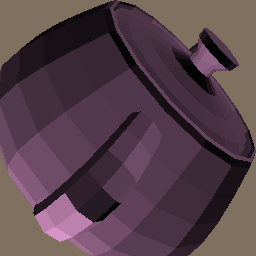

In [1]:
from PIL import Image
import json
import math
# from IPython.display import display


with open('./Teapot.json') as json_file:
    data = json.load(json_file)
w, h = 256, 256
img = Image.new('RGB',(w, h), (127,112,96))
z_buffer = [[math.inf] * 256 for i in range(256)]
data1 = data.get('data')
# print('dataaaa>>',data)
# print('dataaa0>>>',data1[0])
for dat in data1:
  # dat = data1[0]
  xmin = math.floor(min(dat['v0']['v'][0],dat['v1']['v'][0],dat['v2']['v'][0]))
  xmax = math.ceil(max(dat['v0']['v'][0],dat['v1']['v'][0],dat['v2']['v'][0]))
  ymin = math.floor(min(dat['v0']['v'][1],dat['v1']['v'][1],dat['v2']['v'][1]))
  ymax = math.ceil(max(dat['v0']['v'][1],dat['v1']['v'][1],dat['v2']['v'][1]))
  # print('coords>>',xmin,xmax,ymin,ymax)

  nx = dat['v0']['n'][0]
  ny = dat['v0']['n'][1]
  nz = dat['v0']['n'][2]
  dotp = float(0.707 * nx) + float(0.5 * ny) + float(0.5 * nz)

  if dotp < 0.0:
    dotp = -dotp
  elif dotp > 1.0:
    dotp = 1.0
  
  rgb = [float(0.95 * dotp), float(0.65 * dotp), float(0.88 * dotp)]
  col = (int(rgb[0] * 255) ,int(rgb[1] * 255), int(rgb[2] * 255))

  for y in range(ymin,ymax):
    for x in range(xmin, xmax):
      x0 = dat['v0']['v'][0]
      x1 = dat['v1']['v'][0]
      x2 = dat['v2']['v'][0]
      y0 = dat['v0']['v'][1]
      y1 = dat['v1']['v'][1]
      y2 = dat['v2']['v'][1]
      f01 = (y0-y1)*x + (x1-x0)*y + x0*y1 - x1*y0
      f12 = (y1-y2)*x + (x2-x1)*y + x1*y2 - x2*y1
      f20 = (y2-y0)*x + (x0-x2)*y + x2*y0 - x0*y2
      f01a = (y0-y1)*x2 + (x1-x0)*y2 + x0*y1 - x1*y0
      f12a = (y1-y2)*x0 + (x2-x1)*y0 + x1*y2 - x2*y1
      f20a = (y2-y0)*x1 + (x0-x2)*y1 + x2*y0 - x0*y2
      alpha = f12/f12a
      beta = f20/f20a
      gamma = f01/f01a
      z_at_pixel = alpha * dat['v0']['v'][2] + beta * dat['v1']['v'][2] + gamma * dat['v2']['v'][2]
      if(alpha >= 0 and beta >=0 and gamma >= 0):
        if(x >= 0 and y >= 0 and x < 256 and y < 256):
          if z_at_pixel < z_buffer[x][y]:
            img.putpixel((x,y),col)
            z_buffer[x][y] = z_at_pixel
display(img)
